# [Fe/H] Metallicity Profiles (Gas)

In [33]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as ss

In [34]:
from auriga.snapshot import Snapshot
from auriga.images import figure_setup
from auriga.settings import Settings
from auriga.parser import parse

In [35]:
figure_setup()
settings = Settings()

In [36]:
SNAPNUMS = [60, 100, 127]
SIMULATION = "au6_or_l4"
SIMULATIONS = [f"au{i}_or_l4" for i in settings.groups["Included"]]
MAX_TIME = 14.0

In [37]:
def read_data(simulation: str, abundances: tuple) -> pd.DataFrame:
    s = Snapshot(simulation=simulation, loadonlytype=[0])
    s.add_extra_coordinates()
    for abundance in abundances:
        s.add_metal_abundance(of=abundance[0], to=abundance[1])

    is_gas = (s.type == 0)
    is_main_obj = (s.halo == s.halo_idx) & (s.subhalo == s.subhalo_idx)
    mask = is_gas & is_main_obj

    df = pd.DataFrame()
    df["CylindricalRadius_ckpc"] = s.rho[mask]
    for abundance in abundances:
        of, to = abundance
        df[f"[{of}/{to}]"] = s.metal_abundance[f"{of}/{to}"][mask]
    df.time = s.time

    # Remove invalid data
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)

    return df

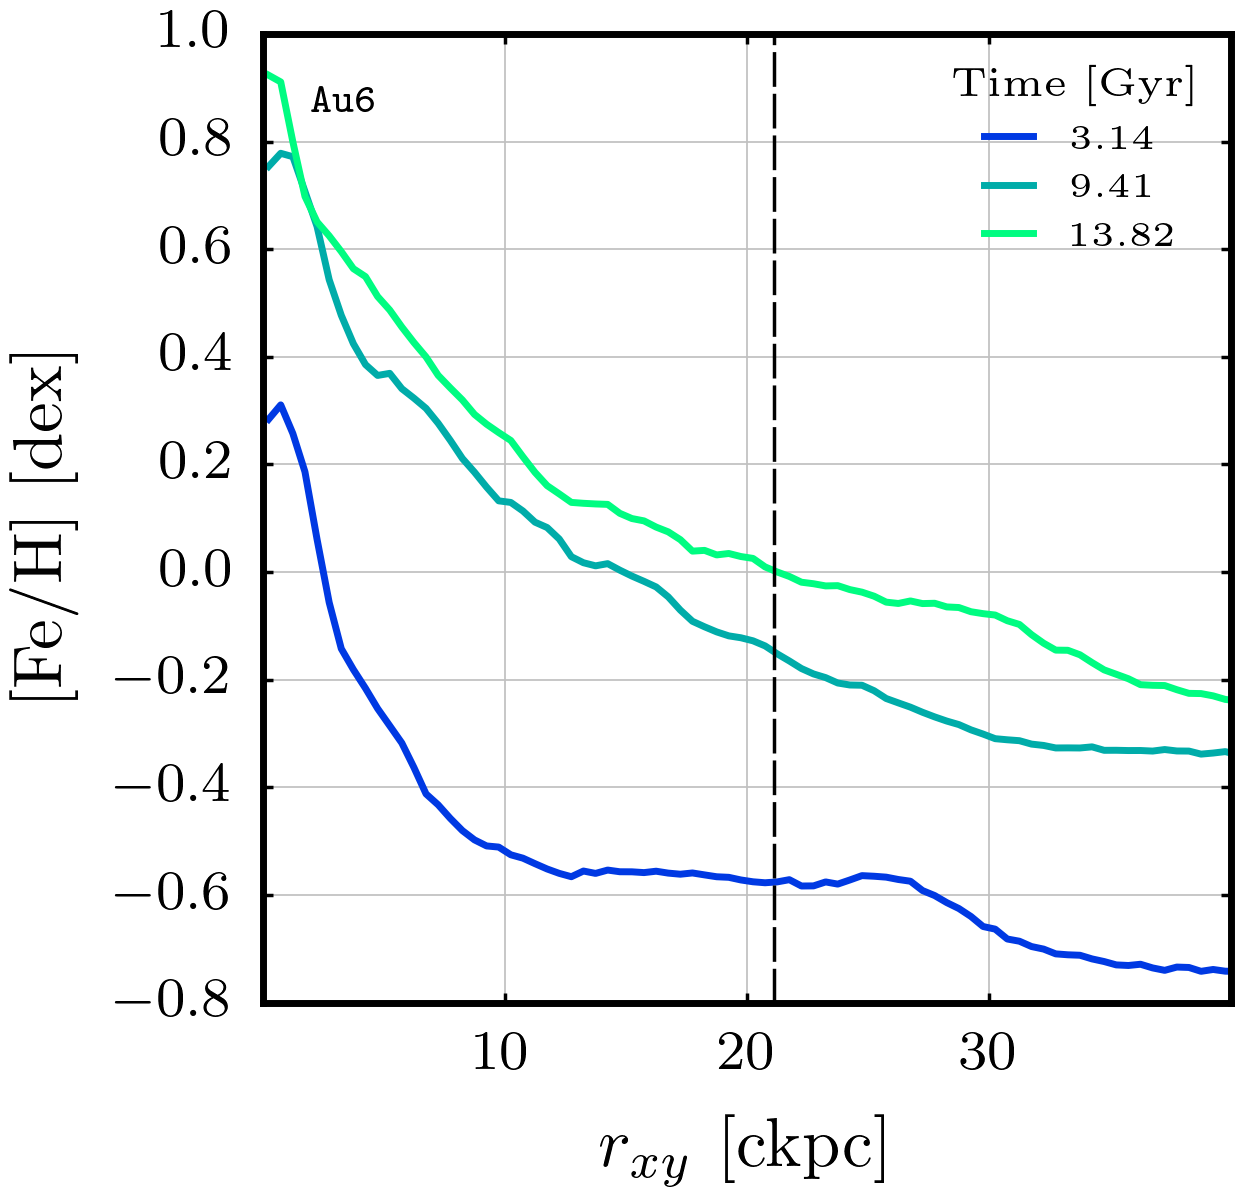

In [38]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))

ax.tick_params(which='both', direction="in")
ax.set_axisbelow(True)
ax.grid(True, ls='-', lw=0.25, c='silver')

ax.set_xlim(0, 40)
ax.set_xticks([10, 20, 30])
ax.set_xlabel(r"$r_{xy}$ [ckpc]")

ax.set_ylabel(r"[Fe/H] [dex]")

galaxy = parse(SIMULATION)[0]
label = f"Au{galaxy}"

for snapnum in SNAPNUMS:
    df = read_data(simulation=SIMULATION + f"_s{snapnum}",
                   abundances=[("Fe", "H")])
    stat, bin_edges, _ = ss.binned_statistic(
        x=df["CylindricalRadius_ckpc"], values=df["[Fe/H]"],
        statistic=np.nanmean, bins=100, range=(0.0, 50.0))
    bin_centers = bin_edges[1:] - np.diff(bin_edges)[0] / 2
    ax.plot(bin_centers, stat, color=plt.cm.winter(df.time / MAX_TIME),
            label=np.round(df.time, 2))

# region Disc Radius Indication
gal_data = pd.read_csv("../data/iza_2022.csv")
disc_radius = gal_data["DiscRadius_kpc"][gal_data["Galaxy"] == galaxy]
disc_radius = disc_radius.values[0]
ax.plot([disc_radius] * 2, ax.get_ylim(), ls=(0, (5, 1)), c='k', lw=0.5)
# endregion

ax.legend(loc="upper right", title="Time [Gyr]", fontsize=5.0, framealpha=0,
          title_fontsize=6.0)

ax.text(x=0.05, y=0.95, s=r"$\texttt{" + label + "}$",
        size=6.0, transform=ax.transAxes, ha='left', va='top')

plt.show()

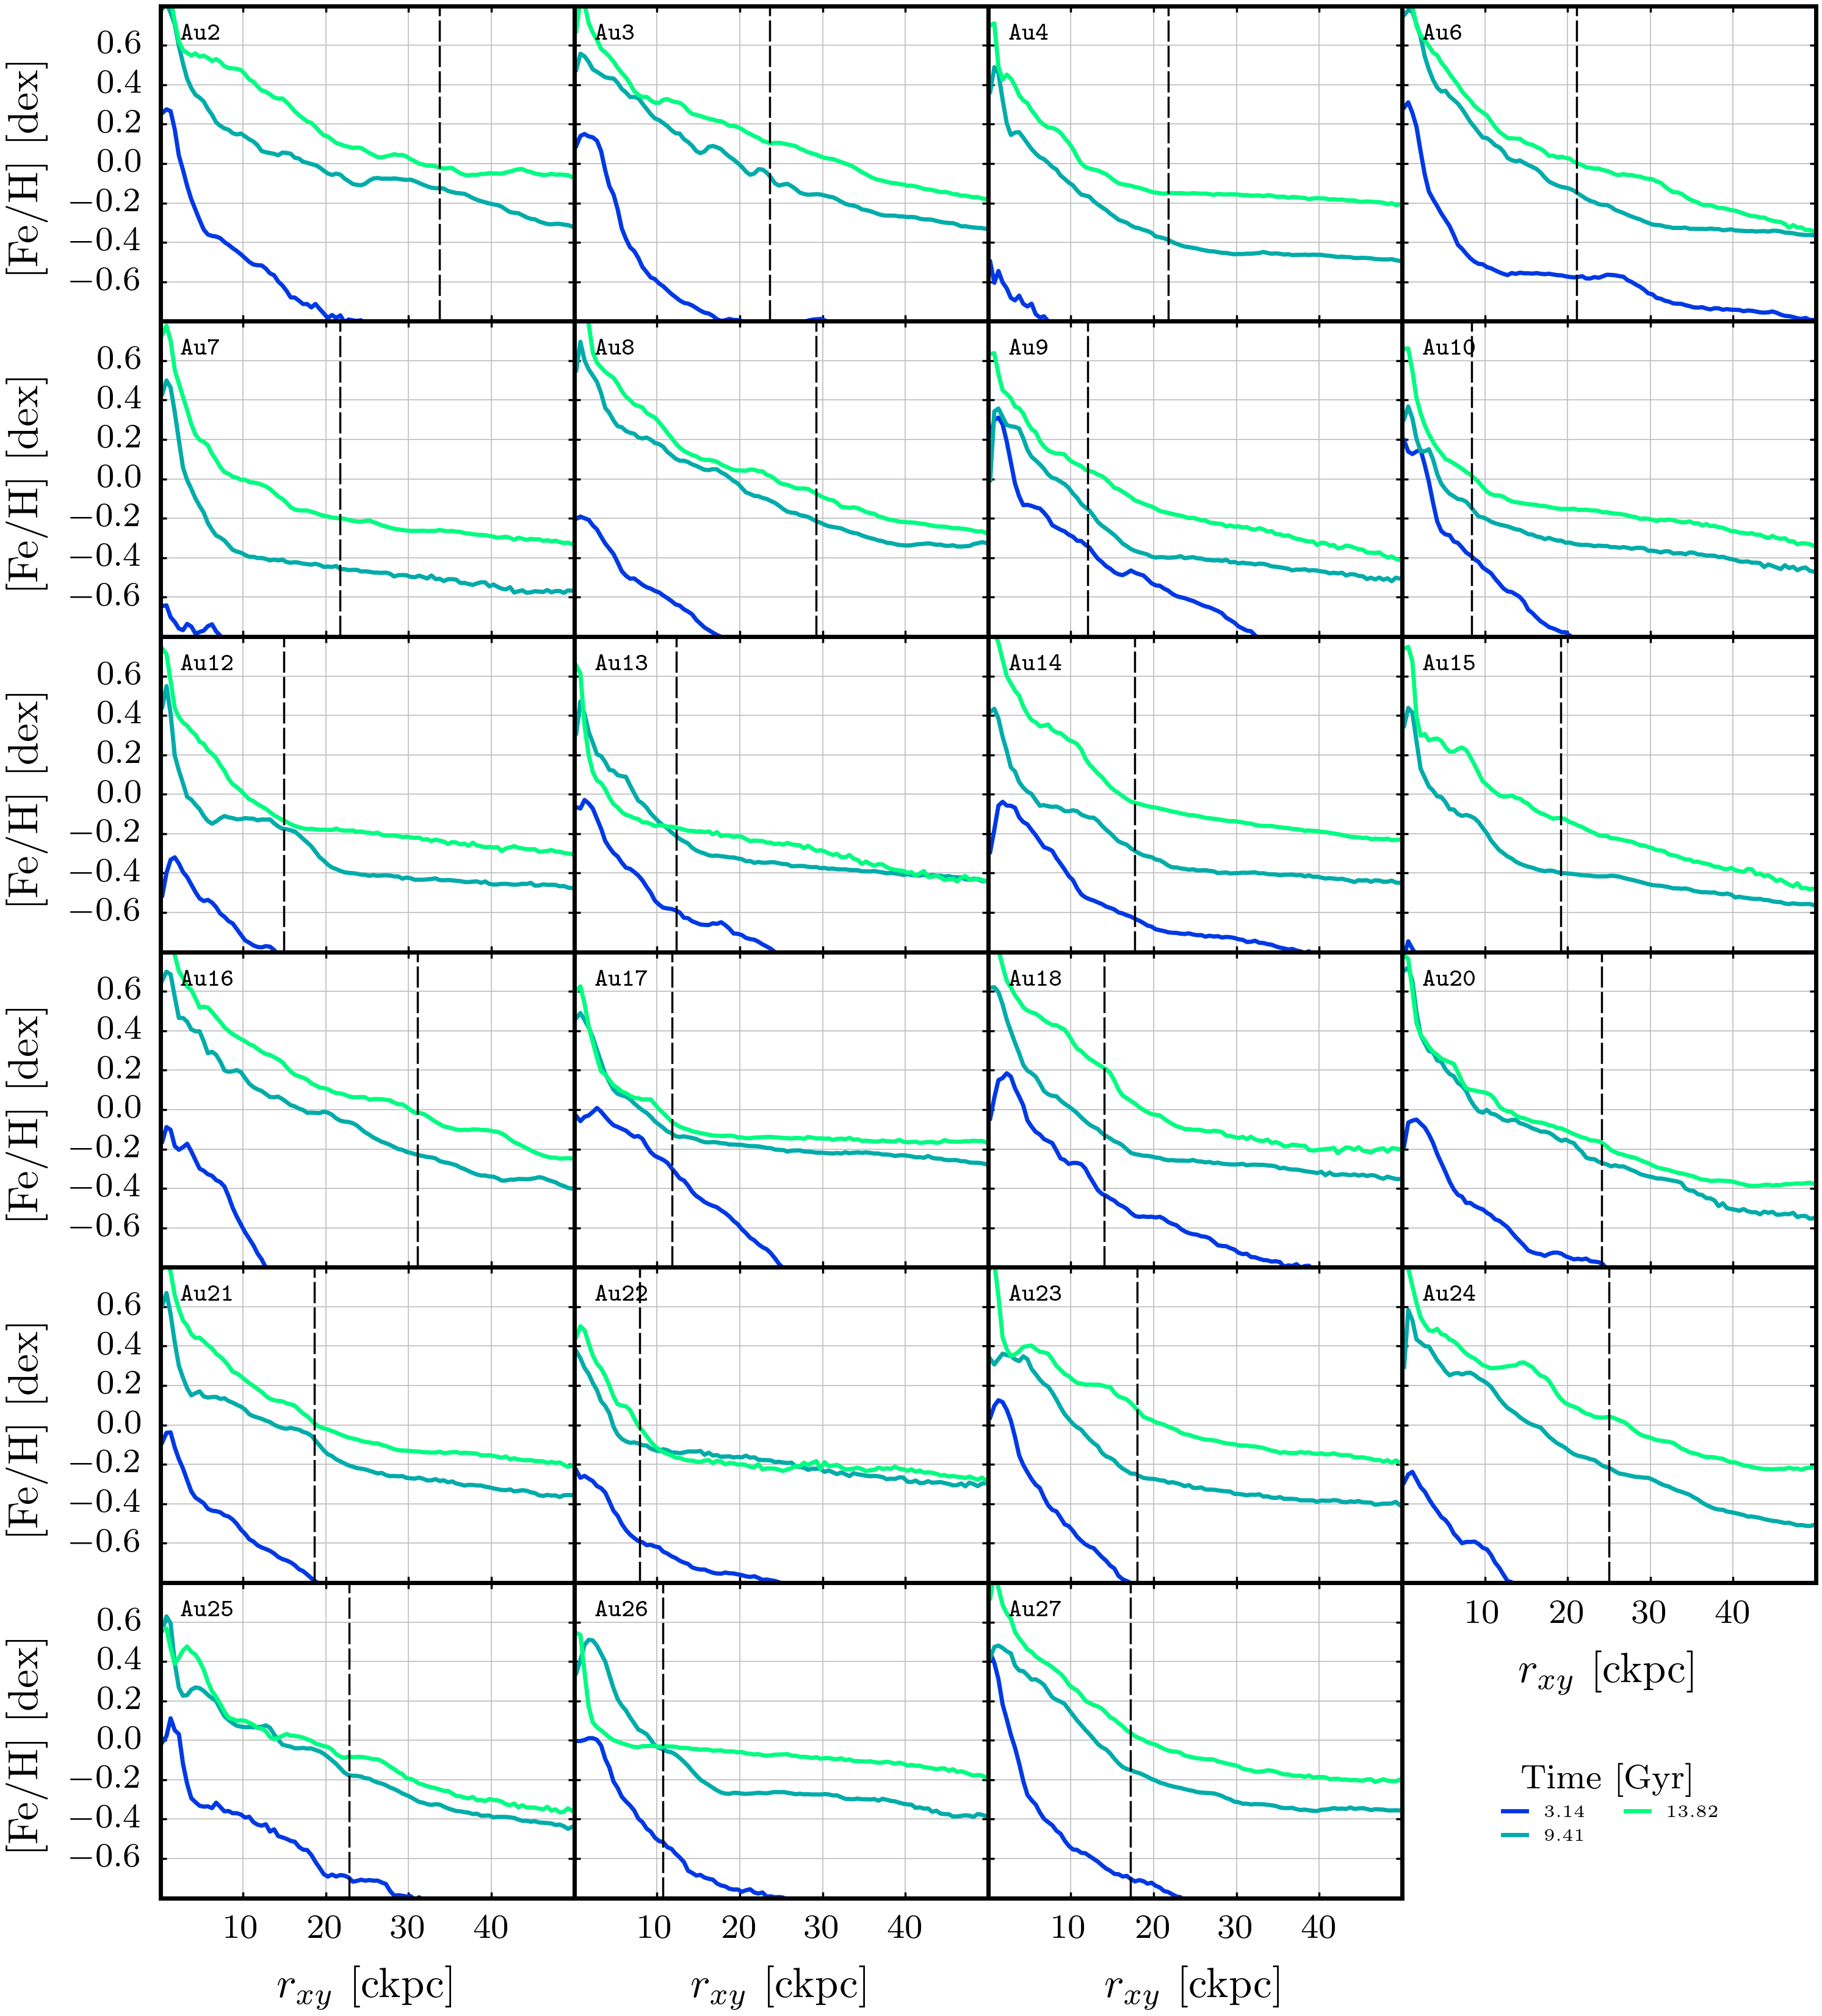

In [42]:
fig = plt.figure(figsize=(7, 8))
gs = fig.add_gridspec(nrows=6, ncols=4, hspace=0.0, wspace=0.0)
axs = gs.subplots(sharex=True, sharey=True)

for ax in axs.flatten():
    ax.tick_params(which='both', direction="in")
    if ax == axs[-1, -1]: ax.axis("off")
    ax.set_xlim(0, 50)
    ax.set_xticks([10, 20, 30, 40])
    ax.set_ylim(-0.8, 0.8)
    ax.set_yticks([-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6])
    ax.grid(True, ls='-', lw=0.25, c='silver')
    ax.set_axisbelow(True)
    if ax.get_subplotspec().is_last_row() or ax == axs[-2, -1]:
        ax.set_xlabel(r"$r_{xy}$ [ckpc]")
        ax.tick_params(labelbottom=True)
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("[Fe/H] [dex]")

for i, simulation in enumerate(SIMULATIONS):
    ax = axs.flatten()[i]
    galaxy = parse(simulation)[0]
    label = f"Au{galaxy}"

    for snapnum in SNAPNUMS:
        df = read_data(simulation=simulation + f"_s{snapnum}",
                       abundances=[("Fe", "H")])
        stat, bin_edges, _ = ss.binned_statistic(
            x=df["CylindricalRadius_ckpc"], values=df["[Fe/H]"],
            statistic=np.nanmean, bins=100, range=(0.0, 50.0))
        bin_centers = bin_edges[1:] - np.diff(bin_edges)[0] / 2
        ax.plot(bin_centers, stat, color=plt.cm.winter(df.time / MAX_TIME),
                label=np.round(df.time, 2))

    # region Disc Radius Indication
    gal_data = pd.read_csv("../data/iza_2022.csv")
    disc_radius = gal_data["DiscRadius_kpc"][gal_data["Galaxy"] == galaxy]
    disc_radius = disc_radius.values[0]
    ax.plot([disc_radius] * 2, ax.get_ylim(), ls=(0, (5, 1)), c='k', lw=0.5)
    # endregion

    if ax == axs[-1, -2]:
        ax.legend(loc="center", bbox_to_anchor=(1.5, 0.3),
                  title="Time [Gyr]", ncol=2, fontsize=4.0, framealpha=0)

    ax.text(x=0.05, y=0.95, s=r"$\texttt{" + label + "}$",
            size=6.0, transform=ax.transAxes, ha='left', va='top')

plt.show()